# TP1 : Web scraping et APIs

Sur la base des éléments méthodologiques et des enseignements techniques présentés lors du cours théorique, il est demandé dans le cadre de ce TP :
- de récupérer les PDFs de tous les bulletins communaux de la Ville de Bruxelles pour la période allant de 1847 à 1978 
- d’expérimenter avec une API ainsi qu’avec le SPARQL endpoint de Wikidata et d’écrire des scripts pour en automatiser l’usage 

À cette fin, vous serez amenés à vous familiariser avec le logiciel de gestion de versions Git et le langage Python.

### Requête SPARQL utile pour les archives de la Ville de Bruxelles

In [13]:
from datetime import datetime as dt
from SPARQLWrapper import SPARQLWrapper, JSON

#### Une première requête simple pour récupérer les bourgmestres de Bruxelles

Inconvénient :
- affichage par ordre alphabétique non pertinent, surtout si le prénom commence par une voyelle accentuée

In [19]:
endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql" 
sparql = SPARQLWrapper(endpoint)

# P39 = fonction occupée par une personne
# Q33126365 = bourgmestre de Bruxelles

statement = """
SELECT DISTINCT ?person ?personLabel ?start ?end WHERE {
    ?person wdt:P39/wdt:P279* wd:Q33126365 .
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE], en" . }
}
ORDER BY ?personLabel
"""

sparql.setQuery(statement) 
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

rows = results['results']['bindings'] 
print(f"{len(rows)} bourgmestres de la Ville de Bruxelles présents dans Wikidata :\n") 

for row in rows:
    print(row['personLabel']['value']) 

47 bourgmestres de la Ville de Bruxelles présents dans Wikidata :

Adolphe Max
Adrien de Grimberghe, seigneur d'Assche
André-Napoléon Fontainas
Antoine de Grimbergen van Assche
Charles Buls
Charles de Brouckère
Charles-Joseph, 4th Duke d'Ursel
Comte Guillaume de Merode, 5th Prince de Rubempré et d'Everberghe
Engelbert Taie
Felix Vanderstraeten
François-Jean Wyns de Raucourt
François-Xavier de Donnea
Freddy Thielemans
Frederick de Marselaer
Gabriel van Bemmel
Guillaume Van Volxem
Hendrik de Bloyere
Henri Joseph Van Langhenhoven
Henri Taye
Hervé Brouhon
Hyacinthe van der Fosse
Jacques Taye
Jan Grauls
Jan-Baptist Verlooy
Jean de Locquenghien
John II of Cottereau, Baron of Jauche
Joseph Van De Meulebroeck
Joseph van der Linden d'Hooghvorst
Jules Anspach
Jules Coelst
Lancelot I Schetz
Lancelot Schetz
Louis Devos
Louis de Wellens van ten Meulenberg
Lucien Cooremans
Marion Lemesre
Michel Demaret
Nicolas-Jean Rouppe
Norbert François Charles van Assche
Paul Arconati-Visconti
Philippe Close
Pier

#### Une deuxième requête parvient à récupérer les "qualifiers" de la propriété P39: "fonction politique"

Inconvénient :
- la requête saisit tous les qualifiers de toutes les fonctions politiques occupées & renseignées en créant des doublons
- tous les bourgmestres n'ont pas de dates de début et de fin associées à la fonction

In [20]:
endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql" 
sparql = SPARQLWrapper(endpoint)

# P39 = fonction occupée par une personne
# Q33126365 = bourgmestre de Bruxelles
# P580 = date de début
# P582 = date de fin

statement = """
SELECT DISTINCT ?person ?personLabel ?fonctionLabel ?starttime ?endtime WHERE {
    ?person wdt:P39 wd:Q33126365 .
    ?person p:P39 ?statement .
    OPTIONAL { ?statement ps:P39 ?fonction .}
    OPTIONAL { ?statement pq:P580 ?starttime .}
    OPTIONAL { ?statement pq:P582 ?endtime .}
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" . }
}
ORDER BY ?starttime
"""

sparql.setQuery(statement) 
sparql.setReturnFormat(JSON)
results = sparql.query().convert() 

rows = results['results']['bindings'] 
print(f"{len(rows)} bourgmestres de la Ville de Bruxelles ?\n") 
date_format = "%Y-%m-%dT%H:%M:%SZ"

for row in rows:
    try:
        starttime = dt.strptime(row['starttime']['value'], date_format) 
        starttime_year = starttime.year
    except ValueError: 
        starttime_year = "????"
    except KeyError:
        starttime_year = "" 
    try:
        endtime = dt.strptime(row['endtime']['value'], date_format) 
        endtime_year = endtime.year
    except ValueError:
        endtime_year = "????"
    except KeyError:
        endtime_year = ""
    print(f"{row['personLabel']['value']} ({starttime_year}-{endtime_year})")

88 bourgmestres de la Ville de Bruxelles ?

Jan-Baptist Verlooy (-)
Paul Arconati-Visconti (-)
Roger-Wauthier van der Noot, 1st Baron of Carloo (-)
Antoine de Grimbergen van Assche (-)
Adolphe Max (-)
Marion Lemesre (-)
Émile de Mot (-)
Émile de Mot (-)
Charles Buls (-)
Frederick de Marselaer (-)
Hendrik de Bloyere (-)
François-Xavier de Donnea (-)
François-Xavier de Donnea (-)
Charles de Brouckère (-)
Charles de Brouckère (-)
André-Napoléon Fontainas (-)
Wilhelmus Bloemart (-)
Wenceslas t'Serclaes (-)
Lucien Cooremans (-)
Michel Demaret (-)
Jules Coelst (-)
Gabriel van Bemmel (-)
Jules Anspach (-)
François-Jean Wyns de Raucourt (-)
Hyacinthe van der Fosse (-)
Hyacinthe van der Fosse (-)
Hyacinthe van der Fosse (-)
Yvan Mayeur (-)
Yvan Mayeur (-)
Joseph Van De Meulebroeck (-)
Jean de Locquenghien (-)
Lancelot Schetz (-)
Henri Joseph Van Langhenhoven (-)
Nicolas-Jean Rouppe (-)
Hervé Brouhon (-)
Henri Taye (1437-1438)
Adrien de Grimberghe, seigneur d'Assche (1488-1489)
John II of Cotter

#### Une troisième requête précise que les qualifiers doivent être rattachés à la fonction politique recherchée

Inconvénients :
- Il manque quelques bougmestres mais la requête semble correcte ; le défaut provient de la qualité des données à la source (date manquante). 
- Je n'ai pas trouvé le moyen d'introduire des options dans la requête entre crochets (à creuser)

Après vérification, la liste est satisfaisante pour les dates à considérer pour les bulletins (il manque quelques "suppléants").

In [21]:
endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql" 
sparql = SPARQLWrapper(endpoint) 

# P39 = fonction occupée par une personne
# Q33126365 = bourgmestre de Bruxelles
# P580 = date de début
# P582 = date de fin

statement = """
SELECT DISTINCT ?person ?personLabel ?starttime ?endtime WHERE {
    ?person wdt:P39 wd:Q33126365 .
    ?person p:P39 [ps:P39 wd:Q33126365;
                   pq:P580 ?starttime;
                   pq:P582 ?endtime].
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" . }
}
ORDER BY ?starttime
"""

sparql.setQuery(statement) 
sparql.setReturnFormat(JSON) 
results = sparql.query().convert() 

rows = results['results']['bindings']
print(f"La lite des {len(rows)} bourgmestres de la Ville de Bruxelles avec leurs dates d'entrée en fonction et de sortie\n")
date_format = "%Y-%m-%dT%H:%M:%SZ"

for row in rows:
    try:
        starttime = dt.strptime(row['starttime']['value'], date_format) 
        starttime_year = starttime.year
    except ValueError: 
        starttime_year = "????"
    except KeyError:
        starttime_year = "" 
    try:
        endtime = dt.strptime(row['endtime']['value'], date_format) 
        endtime_year = endtime.year
    except ValueError:
        endtime_year = "????"
    except KeyError:
        endtime_year = ""
    print(f"{row['personLabel']['value']} ({starttime_year}-{endtime_year})") 

La lite des 35 bourgmestres de la Ville de Bruxelles avec leurs dates d'entrée en fonction et de sortie

Henri Taye (1437-1438)
Adrien de Grimberghe, seigneur d'Assche (1488-1489)
Jacques Taye (1574-1576)
Jacques Taye (1579-1580)
Jacques Taye (1585-1586)
Lancelot I Schetz (1586-1587)
Engelbert Taie (1620-1624)
Norbert François Charles van Assche (1731-1733)
Nicolas-Jean Rouppe (1800-1802)
Louis Devos (1805-1805)
Comte Guillaume de Merode, 5th Prince de Rubempré et d'Everberghe (1805-1809)
Charles-Joseph, 4th Duke d'Ursel (1810-1814)
Joseph van der Linden d'Hooghvorst (1814-1815)
Louis de Wellens van ten Meulenberg (1815-1817)
Hyacinthe van der Fosse (1817-1820)
Louis de Wellens van ten Meulenberg (1820-1830)
Nicolas-Jean Rouppe (1830-1838)
Guillaume Van Volxem (1838-1841)
François-Jean Wyns de Raucourt (1841-1848)
Charles de Brouckère (1848-1860)
André-Napoléon Fontainas (1860-1863)
Jules Anspach (1863-1879)
Felix Vanderstraeten (1879-1881)
Charles Buls (1881-1899)
Émile de Mot (1899-1

### Script d'interrogation d'une API

Pour réaliser cet exercice, j'ai préféré partir d'une source intéressante pour l'étude des bulletins.

Je me suis donc inspirée des API disponibles sur le site de la Ville de Bruxelles qui donne accès à certaines de leurs données : https://opendata.brussels.be

In [22]:
import json
import requests

#### Un premier script teste si une suite de caractères fait partie d'un nom de rue, d'un square ou d'une place dans un des secteurs de la Ville de Bruxelles

Pour affiner le script, j'imprime le set de données par essais/erreurs

In [23]:
rue = "royale"

url = "https://opendata.brussels.be/api/records/1.0/search/"
dataset_ = "bruxelles_rues_par_secteur_pour_les_cartes_de_riverain"
facet_ = "secteur"
data = {'dataset' : dataset_ , 'q' : rue, 'facet' : facet_ }

resp = requests.get(url, data)
json_list = json.loads(resp.text)

sub = json_list['records']

print(len(json_list))
print(json_list)
print(json_list['records'][0]['fields'])

print(len(sub))
print(sub)

record = []

for item in sub:
    record = item['fields']
    print(f"Secteur, lieu : {', '.join(record.values())}")

4
{'nhits': 3, 'parameters': {'dataset': 'bruxelles_rues_par_secteur_pour_les_cartes_de_riverain', 'timezone': 'UTC', 'q': 'royale', 'rows': 10, 'start': 0, 'format': 'json', 'facet': ['secteur']}, 'records': [{'datasetid': 'bruxelles_rues_par_secteur_pour_les_cartes_de_riverain', 'recordid': '07f98425d041ecb8932410e6b86022abd9b32699', 'fields': {'secteur': 'Pentagone', 'rue': 'Royale Place'}, 'record_timestamp': '2017-02-14T11:23:17+00:00'}, {'datasetid': 'bruxelles_rues_par_secteur_pour_les_cartes_de_riverain', 'recordid': 'ed5c643cf284de21a78a987ae013d98c915a0a64', 'fields': {'secteur': 'Pentagone', 'rue': 'Royale  Rue (numéros impairs de 7 à 145 et numéros pairs de 76 à 234)'}, 'record_timestamp': '2017-02-14T11:23:17+00:00'}, {'datasetid': 'bruxelles_rues_par_secteur_pour_les_cartes_de_riverain', 'recordid': 'b20bef9235e554f2d9badf9b082fb50b8ef64f36', 'fields': {'secteur': 'Pentagone', 'rue': 'Royale  Rue (numéros impairs de 7 à 145 et numéros pairs de 2 à 234)'}, 'record_timestam

Après moultes erreurs, je parviens à extraire les champs voulus.

Je remarque qu'il existe des "doublons" et que plusieurs secteurs en dehors de Bruxelles font partie du dataset (ex: Laeken).

In [24]:
# source : https://opendata.brussels.be/api/records/1.0/search/?dataset=bruxelles_rues_par_secteur_pour_les_cartes_de_riverain&q=&facet=secteur

terme = "royale"

url = "https://opendata.brussels.be/api/records/1.0/search/"
dataset_ = "bruxelles_rues_par_secteur_pour_les_cartes_de_riverain"
facet_ = "secteur"
data = {'dataset' : dataset_ , 'q' : terme, 'facet' : facet_ }

resp = requests.get(url, data)
json_list = json.loads(resp.text)
subset = json_list['records']

print(f"Le dataset a détecté {len(subset)} enregistrement(s) pour ce lieu :\n")

for item in subset:
    secteurs = item['fields']['secteur']
    rues = item['fields']['rue']
    print(f"Lieu : {rues} ({secteurs})")

Le dataset a détecté 3 enregistrement(s) pour ce lieu :

Lieu : Royale Place (Pentagone)
Lieu : Royale  Rue (numéros impairs de 7 à 145 et numéros pairs de 76 à 234) (Pentagone)
Lieu : Royale  Rue (numéros impairs de 7 à 145 et numéros pairs de 2 à 234) (Pentagone)


#### Un deuxième script reprend les adresses des fontaines d'eau potable à Bruxelles (sujet abordé dans les bulletins)

In [25]:
url = "https://opendata.brussels.be/api/records/1.0/search/"
dataset_ = "bxl_fontaines"
data = {'dataset' : dataset_}

resp = requests.get(url, data)
json_list = json.loads(resp.text)
subset = json_list['records']

print(f"Bruxelles recense {len(subset)} fontaines d'eau potable :\n")

for item in subset:
    adresses = item['fields']['adrvoisfr']
    specifs = item['fields']['speclocfr']
    print(f"Au {adresses} --> {specifs}")

Bruxelles recense 10 fontaines d'eau potable :

Au 38, Boulevard Anspach --> Au carrefour avec la rue Grétry.
Au 67, Quai au Foin --> Derrière le théatre KVS, sur le terrain de basket.
Au 2, Quai du Batelage --> Rue de l’héliport dans la cour de la «ferme» du parc Maximilien.
Au 106, Rue Neuve --> En face de l’entrée du City 2, au coin de la rue de Malines.
Au 1, Rue de la Loi --> En face à la rue Montagne du Parc, près de l’aire de jeux.
Au 32, Rue aux Laines --> Entrée Rue aux laines, passage M. Yourcenar.
Au 2, Rue de Rollebeek --> Au croisement avec le Boulevard de l’Empereur.
Au 6, Rue des Ursulines --> A gauche de l’entrée de l’Eglise de la Chapelle, au skate parc.
Au 42C, Avenue de l'Héliport --> Entre Bd Simon Bolivar et av de l’héliport, au parc, près de la plaine de jeux.
Au 59, Square Prince Léopold --> En face du n° 49, près Rue Strauwen, au bord de l’allée autour du parc.


#### Un troisième script pour les adresses des théâtres

In [26]:
url = "https://opendata.brussels.be/api/records/1.0/search/"
dataset_ = "bruxelles_theatres"
data = {'dataset' : dataset_}

resp = requests.get(url, data)
json_list = json.loads(resp.text)
subset = json_list['records']

print(f"Bruxelles recense {len(subset)} théâtres :\n")

for item in subset:
    noms = item['fields']['nom']
    rues = item['fields']['rue']
    print(f"{noms} ({rues})")

Bruxelles recense 10 théâtres :

Kaaitheater (Square Sainctelette 20)
Centre culturel des Riches-Claires (Rue des Riches Claires 24)
Théâtre de Poche (Chemin du Gymnase 1A)
(La) Monnaie (Place de la Monnaie)
(Le) Jardin de ma Soeur (Rue du Grand Hospice)
Théâtre des Galeries (Galerie du Roi 32)
Théâtre La Samaritaine (Rue de la Samaritaine 16)
Théâtre royal du Parc (Rue de la Loi 3)
Bronks (Rue du Marché aux Porcs 15-17)
Koninklijke Vlaamse Schouwburg (KVS) (Quai aux Pierres de Taille 7)


#### Un quatrième script pour les cinémas

In [27]:
url = "https://opendata.brussels.be/api/records/1.0/search/"
dataset_ = "bruxelles_cinemas"
data = {'dataset' : dataset_}

resp = requests.get(url, data)
json_list = json.loads(resp.text)
subset = json_list['records']

print(f"Bruxelles recense {len(subset)} cinémas :\n")

for item in subset:
    cinemas = item['fields']['cinema']
    adresses = item['fields']['adresse']
    print(f"{cinemas} ({adresses})")

Bruxelles recense 8 cinémas :

Cinematek (Rue Baron Horta 9 - 1000 Bruxelles)
Kinepolis (Boulevard du Centenaire 2 - 1020 Bruxelles (Laeken))
Galeries (Galerie de la Reine 26 - 1000 Bruxelles)
Cinèma Nova (Rue d'Arenberg 3 - 1000 Bruxelles)
Actor's Studio (Rue de la Fourche 17-19 - 1000 Bruxelles)
Aventure (Rue des Fripiers 15 - 1000 Bruxelles)
Cinema Palace (Boulevard Anspach 85 - 1000 Bruxelles)
UGC De Brouckère (Place De Brouckère 38 - 1000 Bruxelles)


#### Un cinquième script teste le dataset des bourgmestres

Ce dataset est incomplet, tous les champs ne sont pas toujours renseignés et le résultat est très incomplet

In [28]:
url = "https://opendata.brussels.be/api/records/1.0/search/"
dataset_ = "bxl_bourgmestres"
data = {'dataset' : dataset_}

resp = requests.get(url, data)
json_list = json.loads(resp.text)
subset = json_list['records']

print(f"Liste des {len(subset)} bourgmestres présents dans le dataset :\n")

for item in subset:
    bourgmestres = item['fields']['bourgmestres']
    print(f"{bourgmestres}")

Liste des 10 bourgmestres présents dans le dataset :

Michel Demaret
Yvan Mayeur
Adolphe Max
Marion Lemesre
Charles Lemonnier
Baron Joseph 
Van de Meulebroeck
Lucien Cooremans
Nicolas Rouppe
Nicolas Verhulst - Van Hoegaarden
André Fontainas


#### Un dernier script pour le fun et parce que ce sujet est aussi abordé dans le corpus

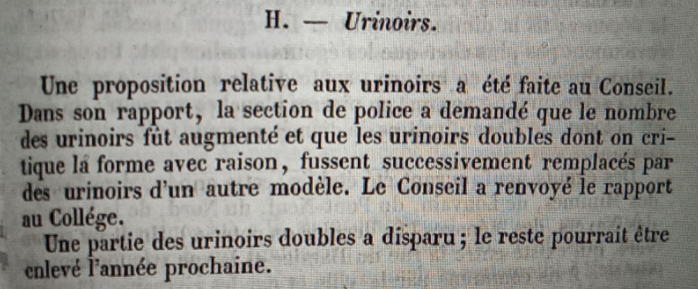

In [29]:
url = "https://opendata.brussels.be/api/records/1.0/search/"
dataset_ = "bruxelles_urinoirs_publics"
data = {'dataset' : dataset_}

resp = requests.get(url, data)
json_list = json.loads(resp.text)
subset = json_list['records']

print(f"Si le besoin presse, n'hésitez pas à vous rendre à l'un de nos {len(subset)} urinoirs publics de la Ville de Bruxelles :\n")

for item in subset:
    descriptions = item['fields']['description']
    adresses = item['fields']['adresse']
    print(f"Au {adresses}")

Si le besoin presse, n'hésitez pas à vous rendre à l'un de nos 10 urinoirs publics de la Ville de Bruxelles :

Au 44, Rue des Artistes
Au 441, Avenue des Pagodes
Au 23B, Rue des Pierres
Au 589, Avenue Louise
Au 8, Place du Nouveau Marché aux Grains
Au 21, Rue Tielemans
Au 387, Rue des Palais Outre-Ponts
Au 142, Boulevard du Midi
Au 38, Rue Saint-Christophe
Au 77, Boulevard Maurice Lemonnier
